# KMeans

아이리스 데이터셋을 사용해 KMeans 를 implement 해봅시다.

In [1]:
import numpy as np
import pandas as pd

## Using sklearn

In [2]:
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris

data = load_iris()
iris = data['data']

km = KMeans(n_clusters = 3, max_iter=5)
km.fit(iris)

KMeans(max_iter=5, n_clusters=3)

이런식으로 KMeans는 n_clusters 를 사전에 지정해 주어야 합니다. 또한, 알고리즘이 무한정 반복하는 것을 방지하기 위해 max_iter 을 지정해 주어야 합니다. 

## Procedure

The procedure is as follows:

1. Randomly select k centroids
2. Assign all points to the nearest centroid
3. Update centroids
4. Repeat until centroids remain fixed

In [3]:
from scipy.spatial import distance
from collections import defaultdict

In [40]:
class CustomKMeans():
    
    def __init__(self, n_clusters, max_iter=10, random_state=42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
    
    def initialize_centroids(self, X):
        
        # Replication 가능하게 시드를 정해줍시다.
        np.random.seed(self.random_state)
        centroids = []
        
        # Randomly select centroids using np.random.choice
        centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False), :]
            
        self.centroids = centroids
            
    def assign_points(self, X):
        
        self.labels_ = np.array([], dtype=int)
        clusters = defaultdict(list)
        
        '''
        For all points in X, 
        
             1. calculate distance to all centroids (distance.cdist)
             2. extract the label of the closest centroid (np.argmin)
             3. append the label to self.labels_
             4. append the point to clusters[label]
        
        Example output format:
        
            self.labels : [0, 0, 1, 1, 2]
            clusters: {0: [[1,1,1,1], [2,2,2,2]],
                       1: [[8,8,8,8], [9,9,9,9]],
                       2: [[55,55,55,55]]}
        ''' 
        
        for point in X:
            
            label = np.argmin(distance.cdist([point], self.centroids))
            self.labels_ = np.append(self.labels_, label)
            clusters[label].append(point)
        
        for label, cluster in clusters.items():
            clusters[label] = np.array(clusters[label])
            
        self.clusters = clusters
            
    def update_centroids(self):
        
        # Initialize new centroids
        new_centroids = np.zeros(self.centroids.shape)
        
        for label, cluster in self.clusters.items():
            
            # Calculate the new center. The resulting centroid may not exist in the real points
            new_centroid = np.mean(cluster, axis=0)   
            new_centroids[label] = new_centroid
            
        return new_centroids
    
    def fit(self, X):
        
        assert len(X.shape) == 2, 'Input should be a 2D numpy array'
        assert X.shape[0] >= self.n_clusters, 'number of points should be >= k' # = 는 의미가 없겠지만..

        # Step 1
        self.initialize_centroids(X)
        
        for iter in range(self.max_iter):

            # Step 2
            self.assign_points(X)

            # Step 3
            new_centroids = self.update_centroids()
            
            # If new centroids are no different from the previous ones, declare convergence
            if np.linalg.norm(new_centroids-self.centroids) < 1e-8:
                break
                
            else:
                self.centroids = new_centroids


## Check!

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

In [41]:
newkm = CustomKMeans(n_clusters=3)
newkm.fit(iris)

From Scratch: (array([0, 1, 2]), array([62, 50, 38]))
Sklearn: (array([0, 1, 2], dtype=int32), array([62, 50, 38]))


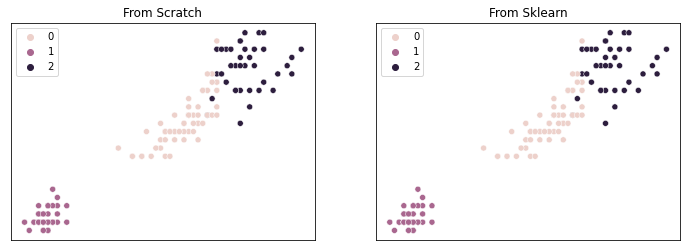

In [42]:
print('From Scratch:', np.unique(newkm.labels_, return_counts=True))
print('Sklearn:', np.unique(km.labels_, return_counts=True))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

scratch = sns.scatterplot(x=iris[:, 2], y=iris[:, 3], hue = newkm.labels_, ax=ax[0])
scratch.set(xticks=[])
scratch.set(yticks=[])
scratch.set_title('From Scratch')
sklearn = sns.scatterplot(x=iris[:, 2], y=iris[:, 3], hue = km.labels_, ax=ax[1])
sklearn.set(xticks=[])
sklearn.set(yticks=[])
sklearn.set_title('From Sklearn')
plt.show()

Sklearn 이랑 조금 다르지만, 그래도 만족할만 합니다. 하지만, 고전적인 KMeans 는 초기화에 굉장히 민감하다는 단점이 있습니다...

Different seed: (array([0, 1, 2]), array([22, 32, 96]))


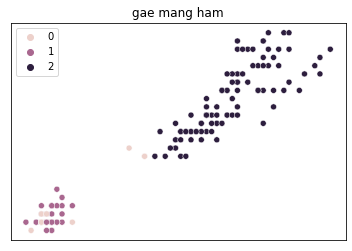

In [43]:
# 다른 random state

newkm = CustomKMeans(n_clusters=3, random_state=43)
newkm.fit(iris)

print('Different seed:', np.unique(newkm.labels_, return_counts=True))

scratch = sns.scatterplot(x=iris[:, 2], y=iris[:, 3], hue = newkm.labels_)
scratch.set(xticks=[])
scratch.set(yticks=[])
scratch.set_title('gae mang ham')
plt.show()

이 문제를 해결하기 위해 sklearn 에서는 k-means++ 가 사용되며, 이것도 부족해서 kmeans 를 여러번 (...) 돌려서 최적의 해를 찾습니다.